TFDS Dataset

Dataset card:
https://www.tensorflow.org/datasets/catalog/cifar10

Contains 60000 images of 10 classes (6000 in each) divided into 50000 and 10000 train and test respectively.

🥇 Goal: To build a classifier with >90% accuracy that classifies images in these categories correctly.

🏢 Architecture:

1. Baseline model with simple Conv2D layers stacked together
2. Transfer Learning using {base-model}

## Setup

Import Libraries and load data

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
train_ds, ds_info = tfds.load('cifar10', split='train[:75%]', shuffle_files=True, as_supervised=True, with_info=True)
val_ds = tfds.load('cifar10', split='train[75%:]', as_supervised=True, shuffle_files=True)
test_ds = tfds.load('cifar10', split='test', as_supervised=True)

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

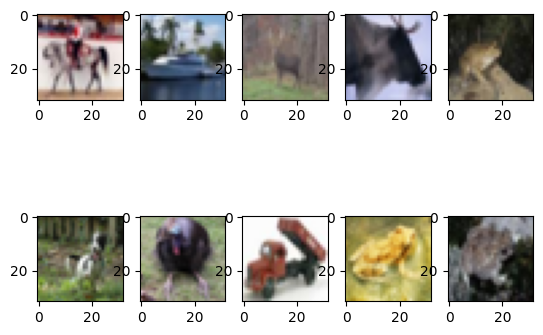

In [ ]:
for i, (image, label) in enumerate(train_ds.take(10)):
    #image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(np.array(image))

In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmp1la23665tfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mult

### Hyperparameters

In [ ]:
BATCH_SIZE = 128
NUM_CLASSES = ds_info.features['label'].num_classes #10
IMAGE_SIZE = ds_info.features['image'].shape

In [ ]:
# num_train_samples = train_ds.reduce(0, lambda x, _:x+1)
# num_val_samples = val_ds.reduce(0, lambda x, _:x+1)
# num_test_samples = test_ds.reduce(0, lambda x, _:x+1)

# print(f"Train Samples:{num_train_samples}")
# print(f"Validation Samples:{num_val_samples}")
# print(f"Test Samples:{num_test_samples}")

### One hot encode labels

In [ ]:
def preprocessing(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32) #this step also scaled values b/w [0, 1)
  label = tf.one_hot(label, depth=NUM_CLASSES)
  return image, label

train_ds = train_ds.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

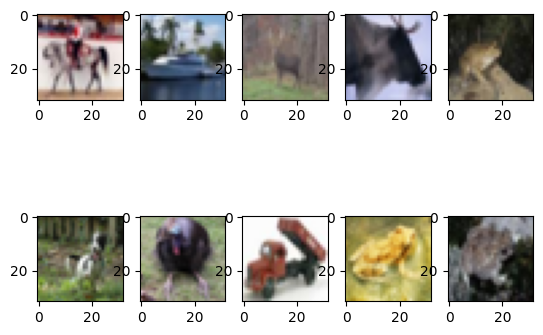

In [ ]:
for i, (image, label) in enumerate(train_ds.take(10)):
  ax = plt.subplot(2, 5, i+1)
  plt.imshow(np.array(image))

### Using Data Augmentation along with a Learning Rate Scheduler

In [ ]:
#data_augmentation_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=15, #changed from default
    width_shift_range=0.1, # changed from default
    height_shift_range=0.1, # changed from default
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True, #changed from default
    vertical_flip=False,
    data_format='channels_last'
)


# def augmentation(image, label):

#   #image_batch, label_batch = sample
#   image = tf.image.random_flip_left_right(image)
#   image = tf.image.random_contrast(image=image, lower=0.1, upper=0.2)
#   image = tf.image.random_flip_up_down(image=image),
#   #image_batch = tf.image.random_crop(value=image_batch, size=(20, 20, 3))
#   return tf.squeeze(image), label

data_augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomRotation(0.2),

]

def augmentation(image):
  for layer in data_augmentation_layers:
    aug_img = layer(image)
    return aug_img

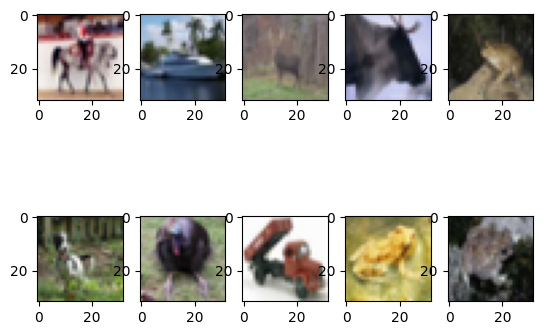

In [ ]:
# original images
for i, (image, label) in enumerate(train_ds.take(10)):
  img = augmentation(image)
  ax = plt.subplot(2, 5, i+1)
  plt.imshow(np.array(img))

In [ ]:
aug_train_ds = train_ds.map(lambda image, label:(augmentation(image), label), num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
aug_train_ds.take(10)

<_TakeDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None))>

### Batch Dataset

In [ ]:
train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

aug_train_ds = aug_train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 10), dtype=tf.float32, name=None))>

## Model Architecture

### Training a model from scratch

In [ ]:
model = tf.keras.models.Sequential([
    #tf.keras.layers.Rescaling(scale=1.0/255, input_shape=IMAGE_SIZE),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(2, 2), activation="relu", kernel_initializer='he_uniform', padding="same", input_shape=IMAGE_SIZE),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(2, 2), activation="relu", kernel_initializer='he_uniform', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(2, 2), activation="relu", kernel_initializer='he_uniform', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation="relu", kernel_initializer='he_uniform'),

    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        416       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 average_pooling2d (Average  (None, 16, 16, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        8256      
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 64)        256       
 chNormalization)                                                
                                                        

In [ ]:
learning_rate = 0.1
lr_drop = 20
momentum = 0.9
decay = 1e-6

In [ ]:
def lr_schedule(epoch):
  return learning_rate * (0.5 ** (epoch // lr_drop))

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     patience=10,
                                     min_delta=0.01),
    tf.keras.callbacks.LearningRateScheduler(lr_schedule)
]

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=decay),
              metrics=tf.keras.metrics.CategoricalAccuracy())

model.fit(train_ds,
          epochs=30,
          validation_data=val_ds,
          callbacks=callbacks)

Epoch 1/30
292/292 [==============================] - 17s 38ms/step - loss: 1.6649 - categorical_accuracy: 0.4162 - val_loss: 1.6074 - val_categorical_accuracy: 0.4138 - lr: 0.1000
Epoch 2/30
292/292 [==============================] - 2s 6ms/step - loss: 1.3223 - categorical_accuracy: 0.5261 - val_loss: 1.2307 - val_categorical_accuracy: 0.5564 - lr: 0.1000
Epoch 3/30
292/292 [==============================] - 2s 8ms/step - loss: 1.1888 - categorical_accuracy: 0.5762 - val_loss: 1.5956 - val_categorical_accuracy: 0.4797 - lr: 0.1000
Epoch 4/30
292/292 [==============================] - 2s 7ms/step - loss: 1.0900 - categorical_accuracy: 0.6150 - val_loss: 2.2217 - val_categorical_accuracy: 0.4340 - lr: 0.1000
Epoch 5/30
292/292 [==============================] - 2s 6ms/step - loss: 1.0149 - categorical_accuracy: 0.6427 - val_loss: 1.1258 - val_categorical_accuracy: 0.6009 - lr: 0.1000
Epoch 6/30
292/292 [==============================] - 2s 6ms/step - loss: 0.9583 - categorical_accuracy

#### Observations so far:

1. Kernel_initializer changed from default "glorot_uniform" to "he_uniform". This created better initialization values.

2. Changed MaxPooling2D to AveragePooling2D to obtain smoother features maps and preserve information (since the image sizes are smaller, this helps as well). Val accuracy moved up from 69% -> 75%

### Transfer Learning

In [ ]:
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE)
base_model.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE),
    #tf.keras.layers.Rescaling(scale=1./255),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 4096)              2101248   
                                                                 
 dropout_10 (Dropout)        (None, 4096)              0         
                                                                 
 dense_15 (Dense)            (None, 10)                40970     
                                                                 
Total params: 16856906 (64.30 MB)
Trainable params: 21

In [ ]:
learning_rate = 0.1
lr_drop = 3
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=decay),
              #optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.55),
              metrics=tf.keras.metrics.CategoricalAccuracy())

model.fit(train_ds,
          epochs=100,
          validation_data=val_ds,
          callbacks=callbacks)

Epoch 1/100
292/292 [==============================] - 4s 9ms/step - loss: 2.2317 - categorical_accuracy: 0.1765 - val_loss: 2.2140 - val_categorical_accuracy: 0.1584 - lr: 0.1000
Epoch 2/100
292/292 [==============================] - 3s 9ms/step - loss: 2.1948 - categorical_accuracy: 0.1817 - val_loss: 1.9976 - val_categorical_accuracy: 0.2799 - lr: 0.1000
Epoch 3/100
292/292 [==============================] - 3s 9ms/step - loss: 2.1701 - categorical_accuracy: 0.1941 - val_loss: 2.2333 - val_categorical_accuracy: 0.1485 - lr: 0.1000
Epoch 4/100
292/292 [==============================] - 2s 8ms/step - loss: 2.1090 - categorical_accuracy: 0.2074 - val_loss: 2.0744 - val_categorical_accuracy: 0.2387 - lr: 0.0500
Epoch 5/100
292/292 [==============================] - 3s 9ms/step - loss: 2.0576 - categorical_accuracy: 0.2286 - val_loss: 1.8951 - val_categorical_accuracy: 0.3496 - lr: 0.0500
Epoch 6/100
292/292 [==============================] - 2s 9ms/step - loss: 2.0521 - categorical_accu

### Train the model end-to-end

In [ ]:
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', pooling='avg', input_shape=IMAGE_SIZE)
base_model.trainable = True

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE),
    #tf.keras.layers.Rescaling(scale=1./255),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 dropout_18 (Dropout)        (None, 256)              

In [ ]:
learning_rate = 0.01
lr_drop = 20
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=decay),
              #optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=tf.keras.metrics.CategoricalAccuracy())

model.fit(train_ds,
          epochs=200,
          validation_data=val_ds,
          callbacks=callbacks)

Epoch 1/200
142/292 [=============>................] - ETA: 2s - loss: 2.3028 - categorical_accuracy: 0.0993

KeyboardInterrupt: 

In [ ]:
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', classes=NUM_CLASSES, input_shape=IMAGE_SIZE)
base_model.trainable = True

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 10)               

In [ ]:
learning_rate = 0.01
lr_drop = 20
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=decay),
              #optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=tf.keras.metrics.CategoricalAccuracy())

model.fit(train_ds,
          epochs=200,
          validation_data=val_ds,
          callbacks=callbacks)

Epoch 1/200
 37/292 [==>...........................] - ETA: 5s - loss: 2.7068 - categorical_accuracy: 0.1491

KeyboardInterrupt: 

Observations:
Transfer Learning with VGG16 has been a disaster. Even after using momentum and decay, the accuracy starts off at 10% and seems to be stuck there for a long time.

⏭ Next: going to try without shuffling the images in the training set, so basically all classes will in order which they are seen.
Also, no val split, we'll be using test_ds as val data.

In [ ]:
train_ds_2 = tfds.load('cifar10', split='train', as_supervised=True)
test_ds_2 = tfds.load('cifar10', split='test', as_supervised=True)

In [ ]:
for image, label in train_ds_2.take(1):
  print(image.shape, label.shape)


(32, 32, 3) ()


In [ ]:
train_ds_2 = train_ds_2.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
test_ds_2 = test_ds_2.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

aug_train_ds_2 = train_ds_2.map(lambda image, label:(augmentation(image), label), num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
for image, label in train_ds_2.take(1):
  print(image.shape, label.shape)


(128, 32, 32, 3) (128, 10)


In [ ]:
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', classes=NUM_CLASSES, input_shape=IMAGE_SIZE)
base_model.trainable = True

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 10)                2

In [ ]:
tf.random.set_seed(42)

learning_rate = 0.01
lr_drop = 20
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=decay),
              #optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=tf.keras.metrics.CategoricalAccuracy())

model.fit(train_ds_2,
          epochs=200,
          validation_data=test_ds_2,
          callbacks=callbacks)

Epoch 1/200
390/390 [==============================] - 19s 41ms/step - loss: 1.8003 - categorical_accuracy: 0.4877 - val_loss: 1.2607 - val_categorical_accuracy: 0.7003 - lr: 0.0100
Epoch 2/200
390/390 [==============================] - 8s 21ms/step - loss: 1.0676 - categorical_accuracy: 0.7695 - val_loss: 0.9912 - val_categorical_accuracy: 0.7919 - lr: 0.0100
Epoch 3/200
390/390 [==============================] - 8s 21ms/step - loss: 0.8655 - categorical_accuracy: 0.8293 - val_loss: 0.9079 - val_categorical_accuracy: 0.8161 - lr: 0.0100
Epoch 4/200
390/390 [==============================] - 8s 21ms/step - loss: 0.7380 - categorical_accuracy: 0.8634 - val_loss: 1.0024 - val_categorical_accuracy: 0.7849 - lr: 0.0100
Epoch 5/200
390/390 [==============================] - 8s 21ms/step - loss: 0.6443 - categorical_accuracy: 0.8848 - val_loss: 0.9238 - val_categorical_accuracy: 0.8094 - lr: 0.0100
Epoch 6/200
390/390 [==============================] - 8s 21ms/step - loss: 0.5677 - categoric

Observations:

WOHOOOO!!!!

Finally!!! Just by not shuffling the dataset, the val_accuracy pushed over to 88%. This is incredible.

⏭ Next: What happens if we pass the unshuffled augmented dataset???

In [ ]:
tf.random.set_seed(42)

base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', classes=NUM_CLASSES, input_shape=IMAGE_SIZE)
base_model.trainable = True

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_13 (Flatten)        (None, 512)               0         
                                                                 
 dropout_25 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 512)               262656    
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 dense_34 (Dense)            (None, 256)               131328    
                                                                 
 dense_35 (Dense)            (None, 10)              

In [ ]:
learning_rate = 0.01
lr_drop = 20
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=decay),
              #optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=tf.keras.metrics.CategoricalAccuracy())

model.fit(aug_train_ds_2,
          epochs=200,
          validation_data=test_ds_2,
          callbacks=callbacks)

Epoch 1/200
390/390 [==============================] - 11s 22ms/step - loss: 1.5908 - categorical_accuracy: 0.5834 - val_loss: 1.1527 - val_categorical_accuracy: 0.7459 - lr: 0.0100
Epoch 2/200
390/390 [==============================] - 8s 21ms/step - loss: 1.0121 - categorical_accuracy: 0.7913 - val_loss: 0.9537 - val_categorical_accuracy: 0.7975 - lr: 0.0100
Epoch 3/200
390/390 [==============================] - 8s 21ms/step - loss: 0.8325 - categorical_accuracy: 0.8407 - val_loss: 0.9345 - val_categorical_accuracy: 0.8153 - lr: 0.0100
Epoch 4/200
390/390 [==============================] - 8s 21ms/step - loss: 0.7125 - categorical_accuracy: 0.8726 - val_loss: 0.9359 - val_categorical_accuracy: 0.8095 - lr: 0.0100
Epoch 5/200
390/390 [==============================] - 8s 22ms/step - loss: 0.6233 - categorical_accuracy: 0.8949 - val_loss: 0.9212 - val_categorical_accuracy: 0.8001 - lr: 0.0100
Epoch 6/200
390/390 [==============================] - 8s 21ms/step - loss: 0.5486 - categoric

In [ ]:
model.save('cifar10vgg16_acc86.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Observations:

Okay, so it wasn't the shuffling that caused the performance improvement.

Turns out the base model was updating from its last updated point everytime it was trained end-to-end. So, the weights were all off.

Good idea to reinitialize the base model everytime it needs to be trained end-to-end.

Also, from the last training cycle, the model doesn't seem to be complex enough to learn patterns, so the loss value is still high.

⏭ Next: Increase the number of FC units in the last two layers and remove the last dropout layer

In [ ]:
tf.random.set_seed(42)

base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', classes=NUM_CLASSES, input_shape=IMAGE_SIZE)
base_model.trainable = True

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4096, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4096, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 4096)              2101248   
                                                                 
 dropout_4 (Dropout)         (None, 4096)              0         
                                                                 
 dense_7 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_8 (Dense)             (None, 10)               

In [ ]:
learning_rate = 0.01
lr_drop = 20
momentum = 0.9
decay = 1e-6
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=decay),
              #optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=tf.keras.metrics.CategoricalAccuracy())

model.fit(aug_train_ds_2,
          epochs=200,
          validation_data=test_ds_2,
          callbacks=callbacks)

Epoch 1/200
390/390 [==============================] - 13s 25ms/step - loss: 3.4694 - categorical_accuracy: 0.6332 - val_loss: 2.9607 - val_categorical_accuracy: 0.7842 - lr: 0.0100
Epoch 2/200
390/390 [==============================] - 9s 24ms/step - loss: 2.8111 - categorical_accuracy: 0.8073 - val_loss: 2.7392 - val_categorical_accuracy: 0.8035 - lr: 0.0100
Epoch 3/200
390/390 [==============================] - 9s 24ms/step - loss: 2.5147 - categorical_accuracy: 0.8506 - val_loss: 2.5632 - val_categorical_accuracy: 0.8136 - lr: 0.0100
Epoch 4/200
390/390 [==============================] - 10s 25ms/step - loss: 2.2739 - categorical_accuracy: 0.8799 - val_loss: 2.3520 - val_categorical_accuracy: 0.8345 - lr: 0.0100
Epoch 5/200
390/390 [==============================] - 9s 24ms/step - loss: 2.0760 - categorical_accuracy: 0.8971 - val_loss: 2.3021 - val_categorical_accuracy: 0.8218 - lr: 0.0100
Epoch 6/200
390/390 [==============================] - 9s 24ms/step - loss: 1.8913 - categori

In [ ]:
model.save('cifar10vgg16_acc88.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
